In [13]:
import requests
import time
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
# Kraken API endpoint
url = "https://api.kraken.com/0/public/OHLC"

# Parameters
pair = "XXBTZUSD"  # BTC/USD pair
#pair = "XETHZUSD"  # ETH/USD pair

interval = 240        # 1440-minute intervals (1day)

# Parameters
short_term_window = 7
long_term_window = 25

In [15]:

# Calculate the Unix timestamp for the start of the week
today = datetime.utcnow().replace(hour=0, minute=0, second=0, microsecond=0)
since = int(time.mktime(today.timetuple()) - timedelta(days=long_term_window).total_seconds())


# Make the API request
response = requests.get(url, params={"pair": pair, "interval": interval, "since": since})
data = response.json()

# Extract and print the hourly prices
if data["error"]:
    print("Error:", data["error"])
else:
    ohlc_data = data["result"][pair] #ohlc stands for open, high, low, close
    for entry in ohlc_data:
        timestamp = datetime.utcfromtimestamp(entry[0])
        open_price = entry[1]
        high_price = entry[2]
        low_price = entry[3]
        close_price = entry[4]
        print(f"Time: {timestamp}, Open: {open_price}, High: {high_price}, Low: {low_price}, Close: {close_price}")


Time: 2025-02-18 04:00:00, Open: 96186.1, High: 96234.6, Low: 95301.0, Close: 95478.1
Time: 2025-02-18 08:00:00, Open: 95478.1, High: 95833.0, Low: 95124.1, Close: 95629.1
Time: 2025-02-18 12:00:00, Open: 95629.1, High: 96650.9, Low: 95176.9, Close: 95504.1
Time: 2025-02-18 16:00:00, Open: 95504.1, High: 95600.0, Low: 93388.7, Close: 94066.6
Time: 2025-02-18 20:00:00, Open: 94066.7, High: 95600.0, Low: 93733.1, Close: 95600.0
Time: 2025-02-19 00:00:00, Open: 95600.0, High: 95831.3, Low: 94996.8, Close: 95639.2
Time: 2025-02-19 04:00:00, Open: 95639.3, High: 95781.0, Low: 95075.4, Close: 95670.6
Time: 2025-02-19 08:00:00, Open: 95670.6, High: 96367.5, Low: 95598.9, Close: 96354.0
Time: 2025-02-19 12:00:00, Open: 96354.0, High: 96682.9, Low: 95578.6, Close: 95911.0
Time: 2025-02-19 16:00:00, Open: 95911.1, High: 96465.8, Low: 95442.1, Close: 96120.8
Time: 2025-02-19 20:00:00, Open: 96120.9, High: 96875.0, Low: 96050.0, Close: 96625.7
Time: 2025-02-20 00:00:00, Open: 96625.7, High: 97291.

In [16]:

needed = []
for entry in ohlc_data:
    timestamp = datetime.utcfromtimestamp(entry[0])
    open_price = entry[1]
    high_price = entry[2]
    low_price = entry[3]
    close_price = entry[4]
    needed.append([timestamp, open_price, high_price, low_price, close_price])


def CreateDF(data):
    df = pd.DataFrame(data, columns=["Time", "Open", "High", "Low", "Close"])
    # Convert the timestamp to datetime
    df["Time"] = pd.to_datetime(df["Time"], unit='s')
    df.set_index("Time", inplace=True)
    
    # Convert price columns to floats
    df["Open"] = df["Open"].astype(float)
    df["High"] = df["High"].astype(float)
    df["Low"] = df["Low"].astype(float)
    df["Close"] = df["Close"].astype(float)
    
    return df



dateframe = CreateDF(needed)
print(dateframe)

                        Open     High      Low    Close
Time                                                   
2025-02-18 04:00:00  96186.1  96234.6  95301.0  95478.1
2025-02-18 08:00:00  95478.1  95833.0  95124.1  95629.1
2025-02-18 12:00:00  95629.1  96650.9  95176.9  95504.1
2025-02-18 16:00:00  95504.1  95600.0  93388.7  94066.6
2025-02-18 20:00:00  94066.7  95600.0  93733.1  95600.0
...                      ...      ...      ...      ...
2025-03-14 20:00:00  84591.1  84591.1  83750.0  83997.6
2025-03-15 00:00:00  83997.7  84659.4  83997.6  84500.7
2025-03-15 04:00:00  84500.8  84559.4  83802.9  83838.9
2025-03-15 08:00:00  83839.0  84121.0  83666.9  84121.0
2025-03-15 12:00:00  84121.0  84473.4  84023.0  84189.4

[153 rows x 4 columns]


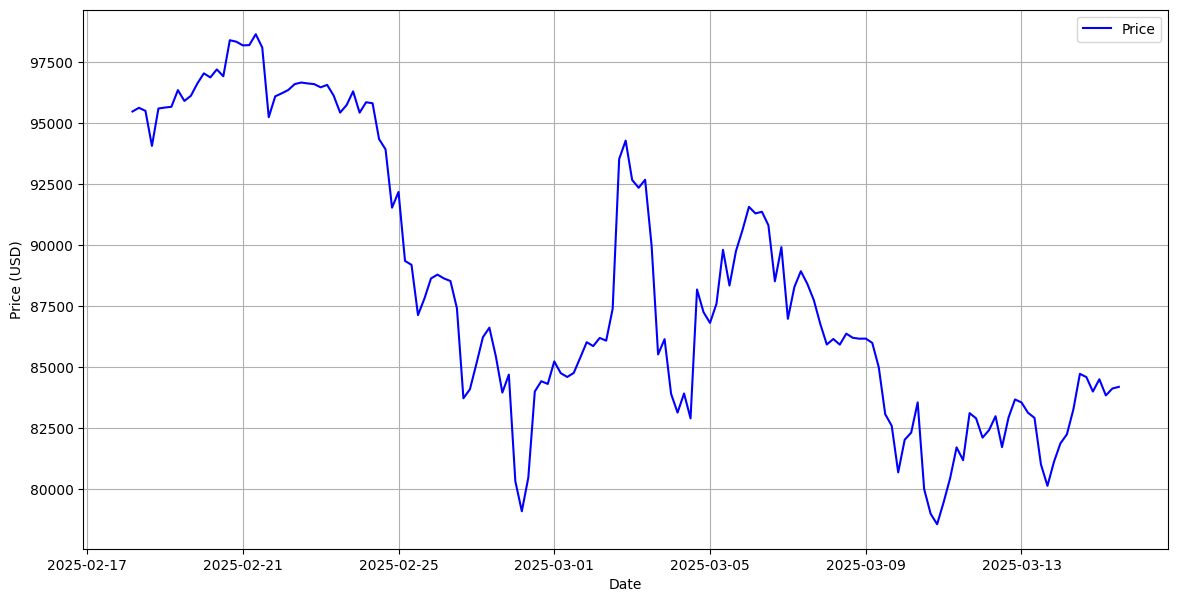

In [17]:
def graph_data(df):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Price', color='blue')    
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid()
    plt.show()

graph_data(dateframe)

In [18]:
def calculate_macd(df):
    df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    return df

dateframe = calculate_macd(dateframe)

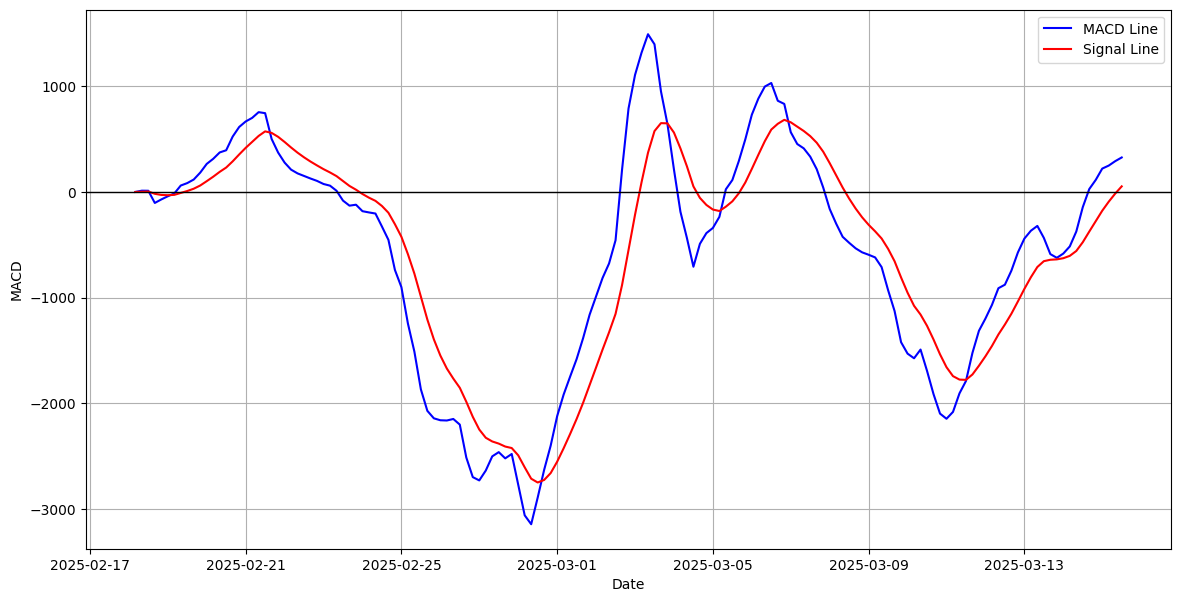

In [19]:
def plot_macd(df):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['MACD'], label='MACD Line', color='blue')
    plt.plot(df.index, df['Signal_Line'], label='Signal Line', color='red')
    plt.axhline(0, color='black', lw=1)
    plt.xlabel('Date')
    plt.ylabel('MACD')
    plt.legend()
    plt.grid()
    plt.show()

plot_macd(dateframe)


In [20]:
initial_balance = 100  # Starting balance in USD
btc_balance = 0
position = False
buy_price = 0
trade_log = []

def simulate_trading(df):
    global initial_balance, btc_balance, position, buy_price

    for i in range(1, len(df)):
        # Check for BUY signal (MACD crosses above Signal Line)
        if df['MACD'].iloc[i] > df['Signal_Line'].iloc[i] and df['MACD'].iloc[i - 1] <= df['Signal_Line'].iloc[i - 1]:
            if not position:
                # BUY action
                buy_price = df['Close'].iloc[i]
                btc_balance = initial_balance / buy_price
                initial_balance = 0
                position = True
                trade_log.append({
                    'Date': df.index[i],
                    'Action': 'BUY',
                    'Price': buy_price,
                    'BTC Balance': btc_balance,
                    'USD Balance': initial_balance
                })
                print(f"BUY at {buy_price:.2f} on {df.index[i].date()}")

        # Check for SELL signal (MACD crosses below Signal Line)
        elif df['MACD'].iloc[i] < df['Signal_Line'].iloc[i] and df['MACD'].iloc[i - 1] >= df['Signal_Line'].iloc[i - 1]:
            if position:
                # SELL action
                sell_price = df['Close'].iloc[i]
                initial_balance = btc_balance * sell_price
                btc_balance = 0
                position = False
                trade_log.append({
                    'Date': df.index[i],
                    'Action': 'SELL',
                    'Price': sell_price,
                    'BTC Balance': btc_balance,
                    'USD Balance': initial_balance
                })
                print(f"SELL at {sell_price:.2f} on {df.index[i].date()}")

    # Final value if holding BTC
    if position:
        final_price = df['Close'].iloc[-1]
        initial_balance = btc_balance * final_price
        trade_log.append({
            'Date': df.index[-1],
            'Action': 'FINAL SELL',
            'Price': final_price,
            'BTC Balance': 0,
            'USD Balance': initial_balance
        })
        print(f"FINAL SELL at {final_price:.2f} on {df.index[-1].date()}")

simulate_trading(dateframe)

BUY at 95629.10 on 2025-02-18
SELL at 94066.60 on 2025-02-18
BUY at 95670.60 on 2025-02-19
SELL at 95243.30 on 2025-02-21
BUY at 84421.70 on 2025-02-28
SELL at 86144.70 on 2025-03-03
BUY at 89805.40 on 2025-03-05
SELL at 86979.40 on 2025-03-07
BUY at 83112.90 on 2025-03-11
FINAL SELL at 84189.40 on 2025-03-15


In [21]:
trade_log_df = pd.DataFrame(trade_log)
print(trade_log_df)

                 Date      Action    Price  BTC Balance  USD Balance
0 2025-02-18 08:00:00         BUY  95629.1     0.001046     0.000000
1 2025-02-18 16:00:00        SELL  94066.6     0.000000    98.366083
2 2025-02-19 04:00:00         BUY  95670.6     0.001028     0.000000
3 2025-02-21 16:00:00        SELL  95243.3     0.000000    97.926744
4 2025-02-28 16:00:00         BUY  84421.7     0.001160     0.000000
5 2025-03-03 20:00:00        SELL  86144.7     0.000000    99.925375
6 2025-03-05 08:00:00         BUY  89805.4     0.001113     0.000000
7 2025-03-07 00:00:00        SELL  86979.4     0.000000    96.780919
8 2025-03-11 16:00:00         BUY  83112.9     0.001164     0.000000
9 2025-03-15 12:00:00  FINAL SELL  84189.4     0.000000    98.034451


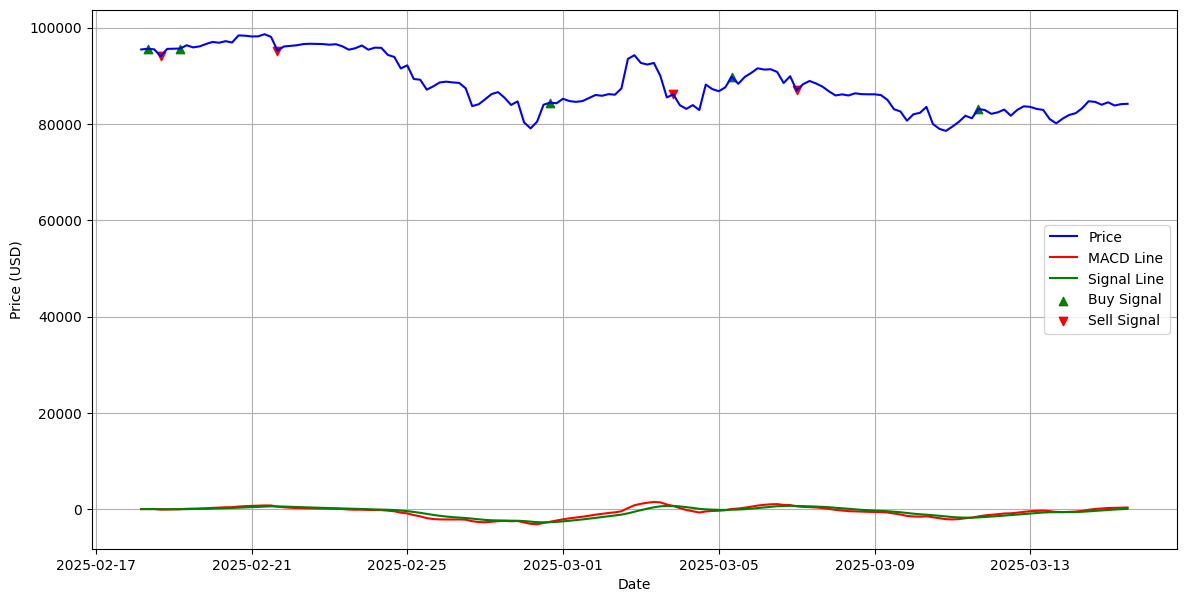

In [22]:
def plot_trades(df, trades):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Price', color='blue')
    plt.plot(df.index, df['MACD'], label='MACD Line', color='red')
    plt.plot(df.index, df['Signal_Line'], label='Signal Line', color='green')

    # Plot Buy signals
    buys = trades[trades['Action'] == 'BUY']
    plt.scatter(buys['Date'], buys['Price'], marker='^', color='green', label='Buy Signal', alpha=1)

    # Plot Sell signals
    sells = trades[trades['Action'] == 'SELL']
    plt.scatter(sells['Date'], sells['Price'], marker='v', color='red', label='Sell Signal', alpha=1)

    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid()
    plt.show()


plot_trades(dateframe, trade_log_df)

In [23]:
initial_value = 100
final_value = initial_balance
profit = final_value - initial_value
roi = (profit / initial_value) * 100

print(f"Initial Balance: ${initial_value:.2f}")
print(f"Final Balance: ${final_value:.2f}")
print(f"Profit: ${profit:.2f}")
print(f"ROI: {roi:.2f}%")

Initial Balance: $100.00
Final Balance: $98.03
Profit: $-1.97
ROI: -1.97%
